In [1]:
import numpy as np
import scipy
import random
import glob
import csv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics import roc_auc_score, roc_curve
%env TORCH_EXTENSIONS_DIR=.
from bindenergy import *
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})

env: TORCH_EXTENSIONS_DIR=.


/home/wjin/miniconda3/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Protein-Ligand Binding

Load model (DrugAllAtomEnergyModel considers the full-atom structure of a protein-ligand complex, including side-chains).

In [3]:
fn = "ckpts/model.drug.allatom"
model_ckpt, opt_ckpt, model_args = torch.load(fn)
model = DrugAllAtomEnergyModel(model_args).cuda()
model.load_state_dict(model_ckpt)
model.eval()

DrugAllAtomEnergyModel(
  (mse_loss): MSELoss()
  (mpn): MPNEncoder(
    (dropout_layer): Dropout(p=0.1, inplace=False)
    (act_func): ReLU()
    (W_i): Linear(in_features=147, out_features=256, bias=False)
    (W_h): Linear(in_features=256, out_features=256, bias=False)
    (W_o): Linear(in_features=389, out_features=256, bias=True)
  )
  (encoder): AllAtomEncoder(
    (W_bind): Linear(in_features=256, out_features=256, bias=True)
    (W_tgt): Linear(in_features=2560, out_features=256, bias=True)
    (A_bind): Embedding(38, 256)
    (A_tgt): Embedding(38, 256)
    (encoder): SRUpp(
      (rnn_lst): ModuleList(
        (0): SRUppCell(515, 128, dropout=0.1, bidirectional=True, highway_bias=-2.0,
          transform_module=SRUppAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (linear1): Linear(in_features=515, out_features=128, bias=False)
          (linear2): Linear(in_features=128, out_features=256, bias=False)
          (linear3): Linear(in_features=128, out_fe

In our NeurIPS paper, we used the PDBBind core (CASF 2016) as the test set. We use the docking test set from EquiBind (Starks et al., ICML 2022)as our validation set.

In our new biorxiv paper, we further evaluate DSMBind on Merck free energy perturbation (FEP) benchmark.

In [4]:
test_casf16 = DrugDataset("data/drug/test_casf16.pkl", 50)
test_equibind = DrugDataset("data/drug/test_equibind.pkl", 50)
test_fep = DrugDataset("data/drug/test_fep.pkl", 50)

 22%|██▏       | 62/285 [00:00<00:00, 619.61it/s]

100%|██████████| 264/264 [00:00<00:00, 879.45it/s]


In [5]:
embedding = load_esm_embedding(test_equibind.data + test_casf16.data + test_fep.data, ['target_seq'])

100%|██████████| 498/498 [02:02<00:00,  4.07it/s]


Inference script (note: DSMBind predicted score is the higher the better, while binding affinity is the lower the better)

In [6]:
def pdbbind_evaluate(model, data, embedding, args):
    model.eval()
    score = []
    label = []
    with torch.no_grad():
        for entry in tqdm(data):
            binder, target = DrugDataset.make_bind_batch([entry], embedding, args)
            pred = model.predict(binder, target)
            score.append(-1.0 * pred.item())
            label.append(entry['affinity'])
    return scipy.stats.spearmanr(score, label)[0], score, label

Make predictions on CASF-2016/Equibind test sets 

In [7]:
casf16_corr, casf16_score, casf16_label = pdbbind_evaluate(
    model, test_casf16, embedding, model_args
)
equibind_corr, equibind_score, equibind_label = pdbbind_evaluate(
    model, test_equibind, embedding, model_args
)

  0%|          | 0/285 [00:00<?, ?it/s]/home/wjin/bindenergy/bindenergy/models/frame.py:21: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion.
L, _ = torch.symeig(A, upper=upper)
should be replaced with
L = torch.linalg.eigvalsh(A, UPLO='U' if upper else 'L')
and
L, V = torch.symeig(A, eigenvectors=True)
should be replaced with
L, V = torch.linalg.eigh(A, UPLO='U' if upper else 'L') (Triggered internally at /opt/conda/conda-bld/pytorch_1670525552411/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2794.)
  _, V = torch.symeig(C.detach(), True)  # [B,3,3]
100%|██████████| 363/363 [00:03<00:00, 101.18it/s]


Text(0.5, 1.0, 'CASF 2016 Spearman R = 0.6429')

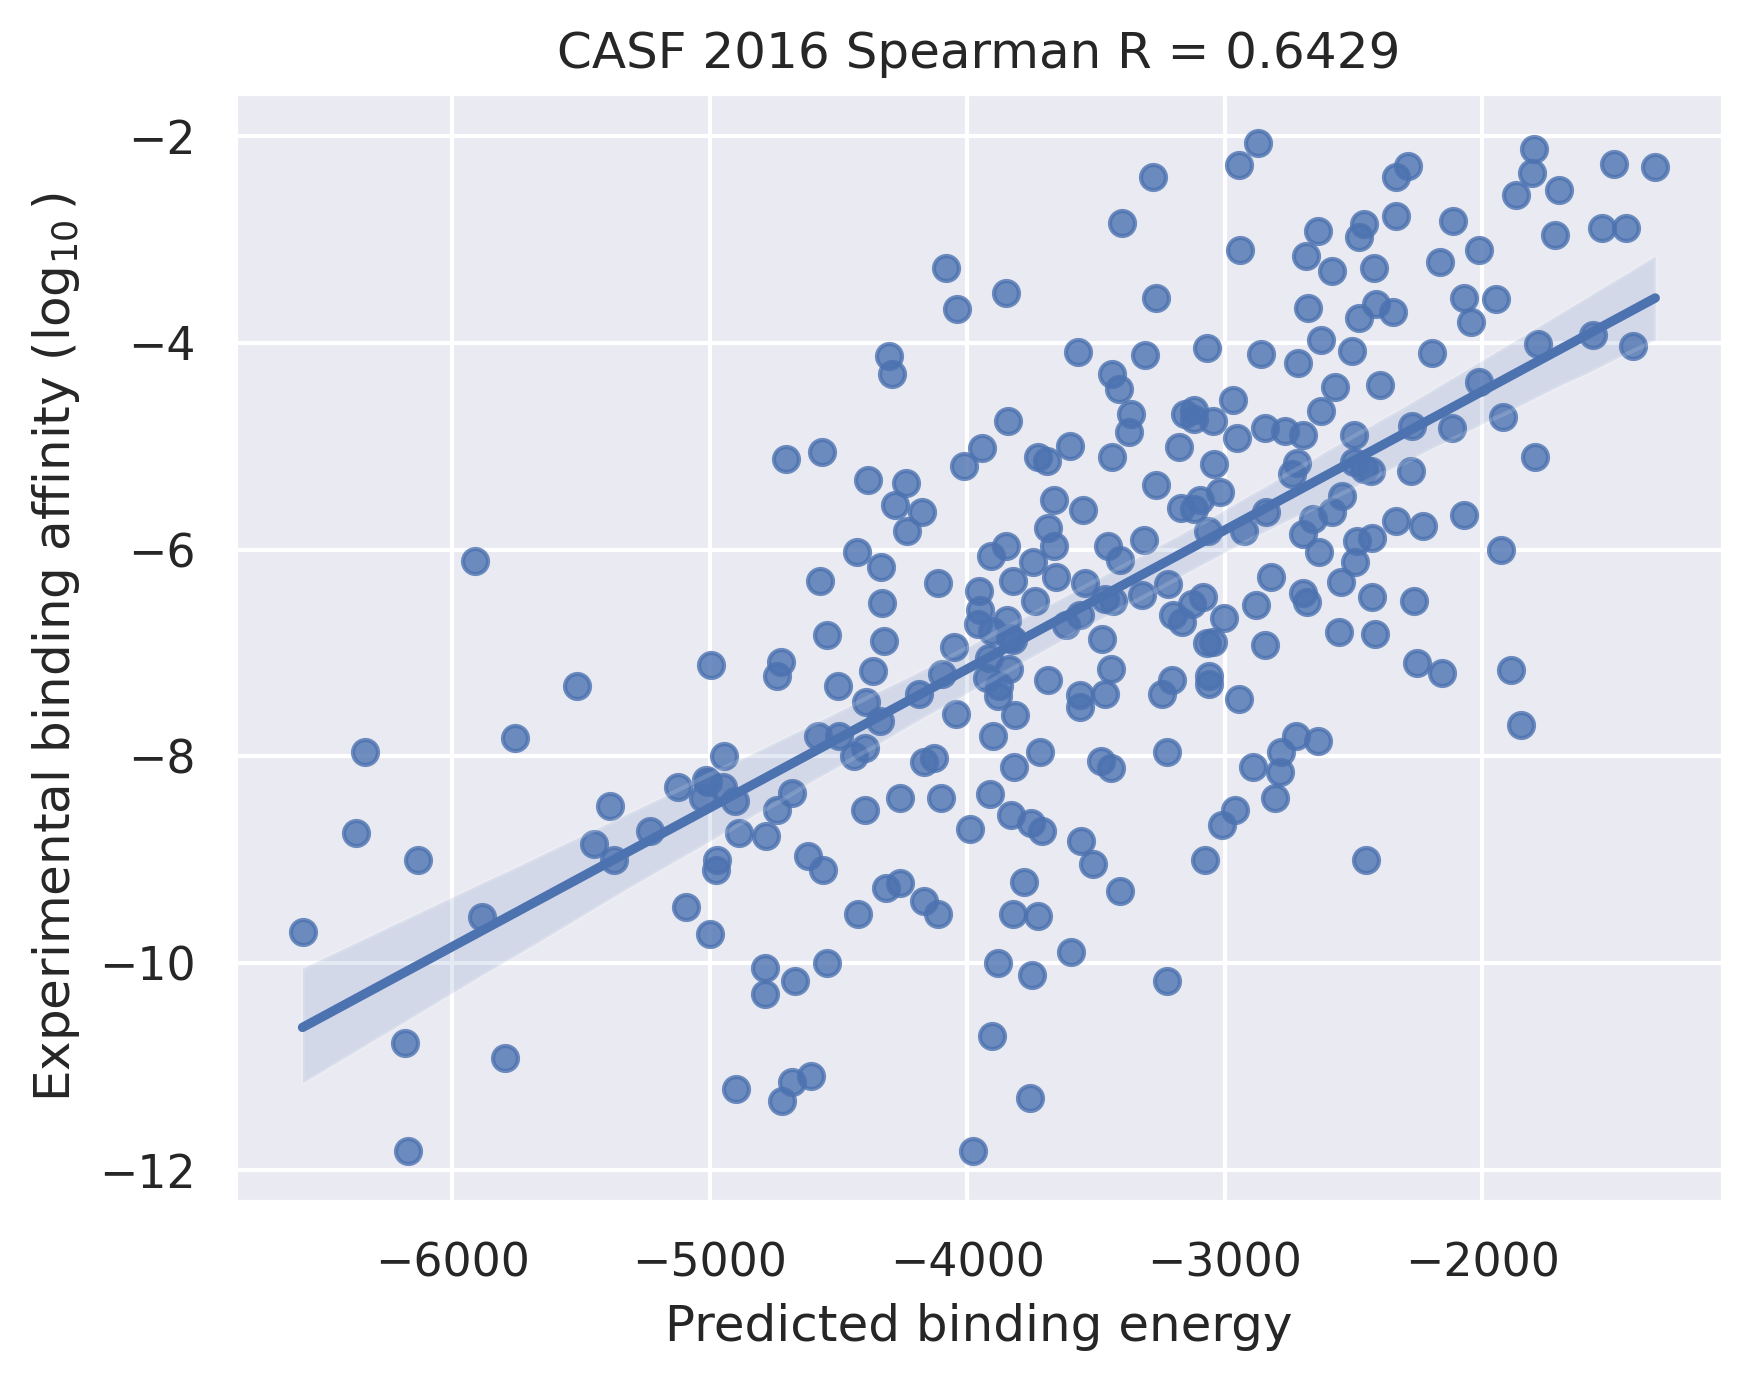

In [8]:
sns.regplot(x=casf16_score, y=casf16_label)
plt.xlabel('Predicted binding energy')
plt.ylabel('Experimental binding affinity ($\log_{10}$)')
plt.title(f'CASF 2016 Spearman R = {casf16_corr:.4f}')

Text(0.5, 1.0, 'Equibind test Spearman R = 0.5268')

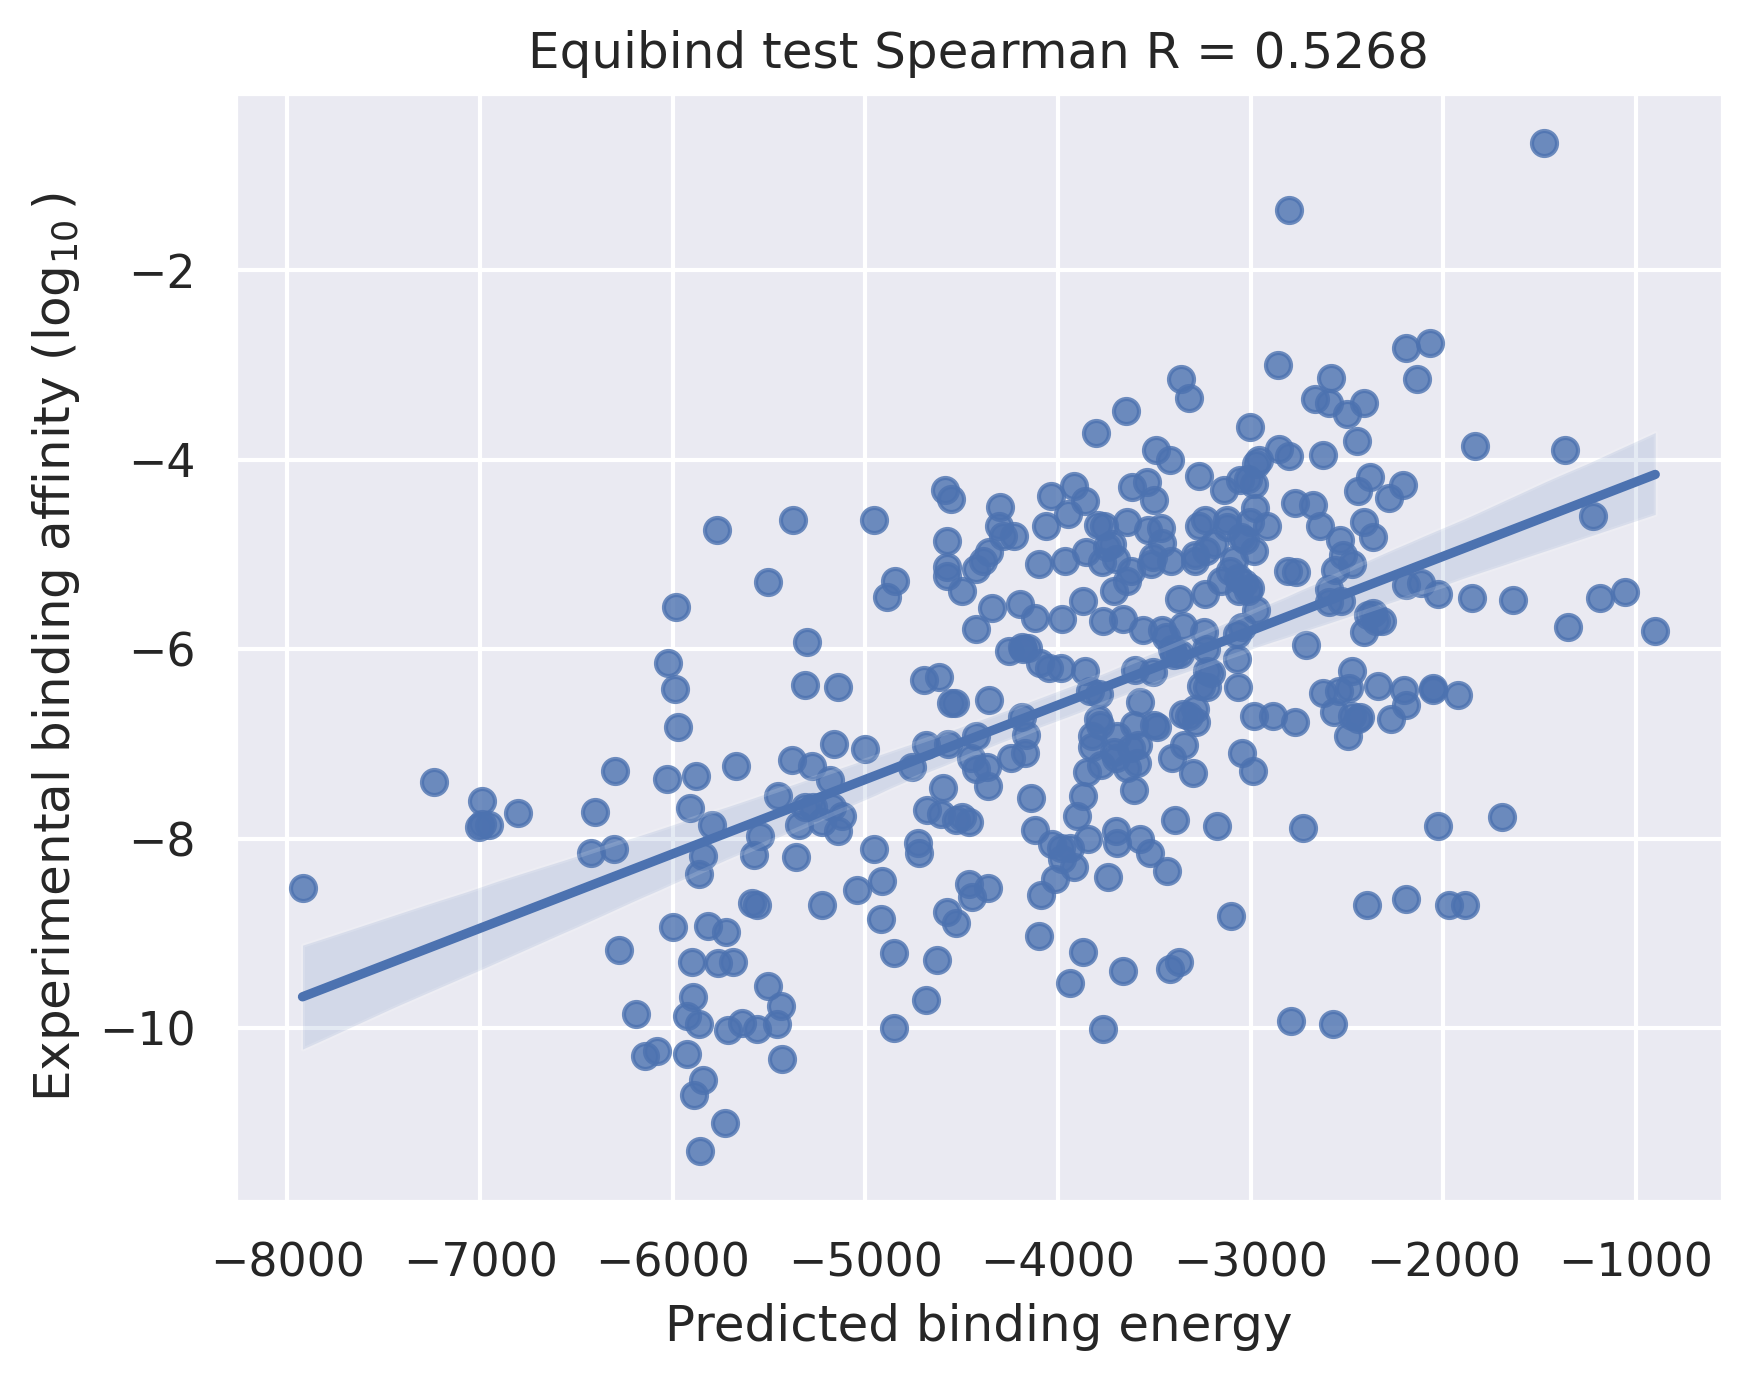

In [9]:
sns.regplot(x=equibind_score, y=equibind_label)
plt.xlabel('Predicted binding energy')
plt.ylabel('Experimental binding affinity ($\log_{10}$)')
plt.title(f'Equibind test Spearman R = {equibind_corr:.4f}')

##### Merck FEP Benchmark Evaluation

In [10]:
score = defaultdict(list)
label = defaultdict(list)
with torch.no_grad():
    for entry in tqdm(test_fep):
        pdb = entry['pdb']
        binder, target = DrugDataset.make_bind_batch([entry], embedding, model_args)
        pred = model.predict(binder, target)
        score[pdb].append(pred.item())
        label[pdb].append(-1.0 * entry['affinity'])

100%|██████████| 264/264 [00:02<00:00, 117.31it/s]


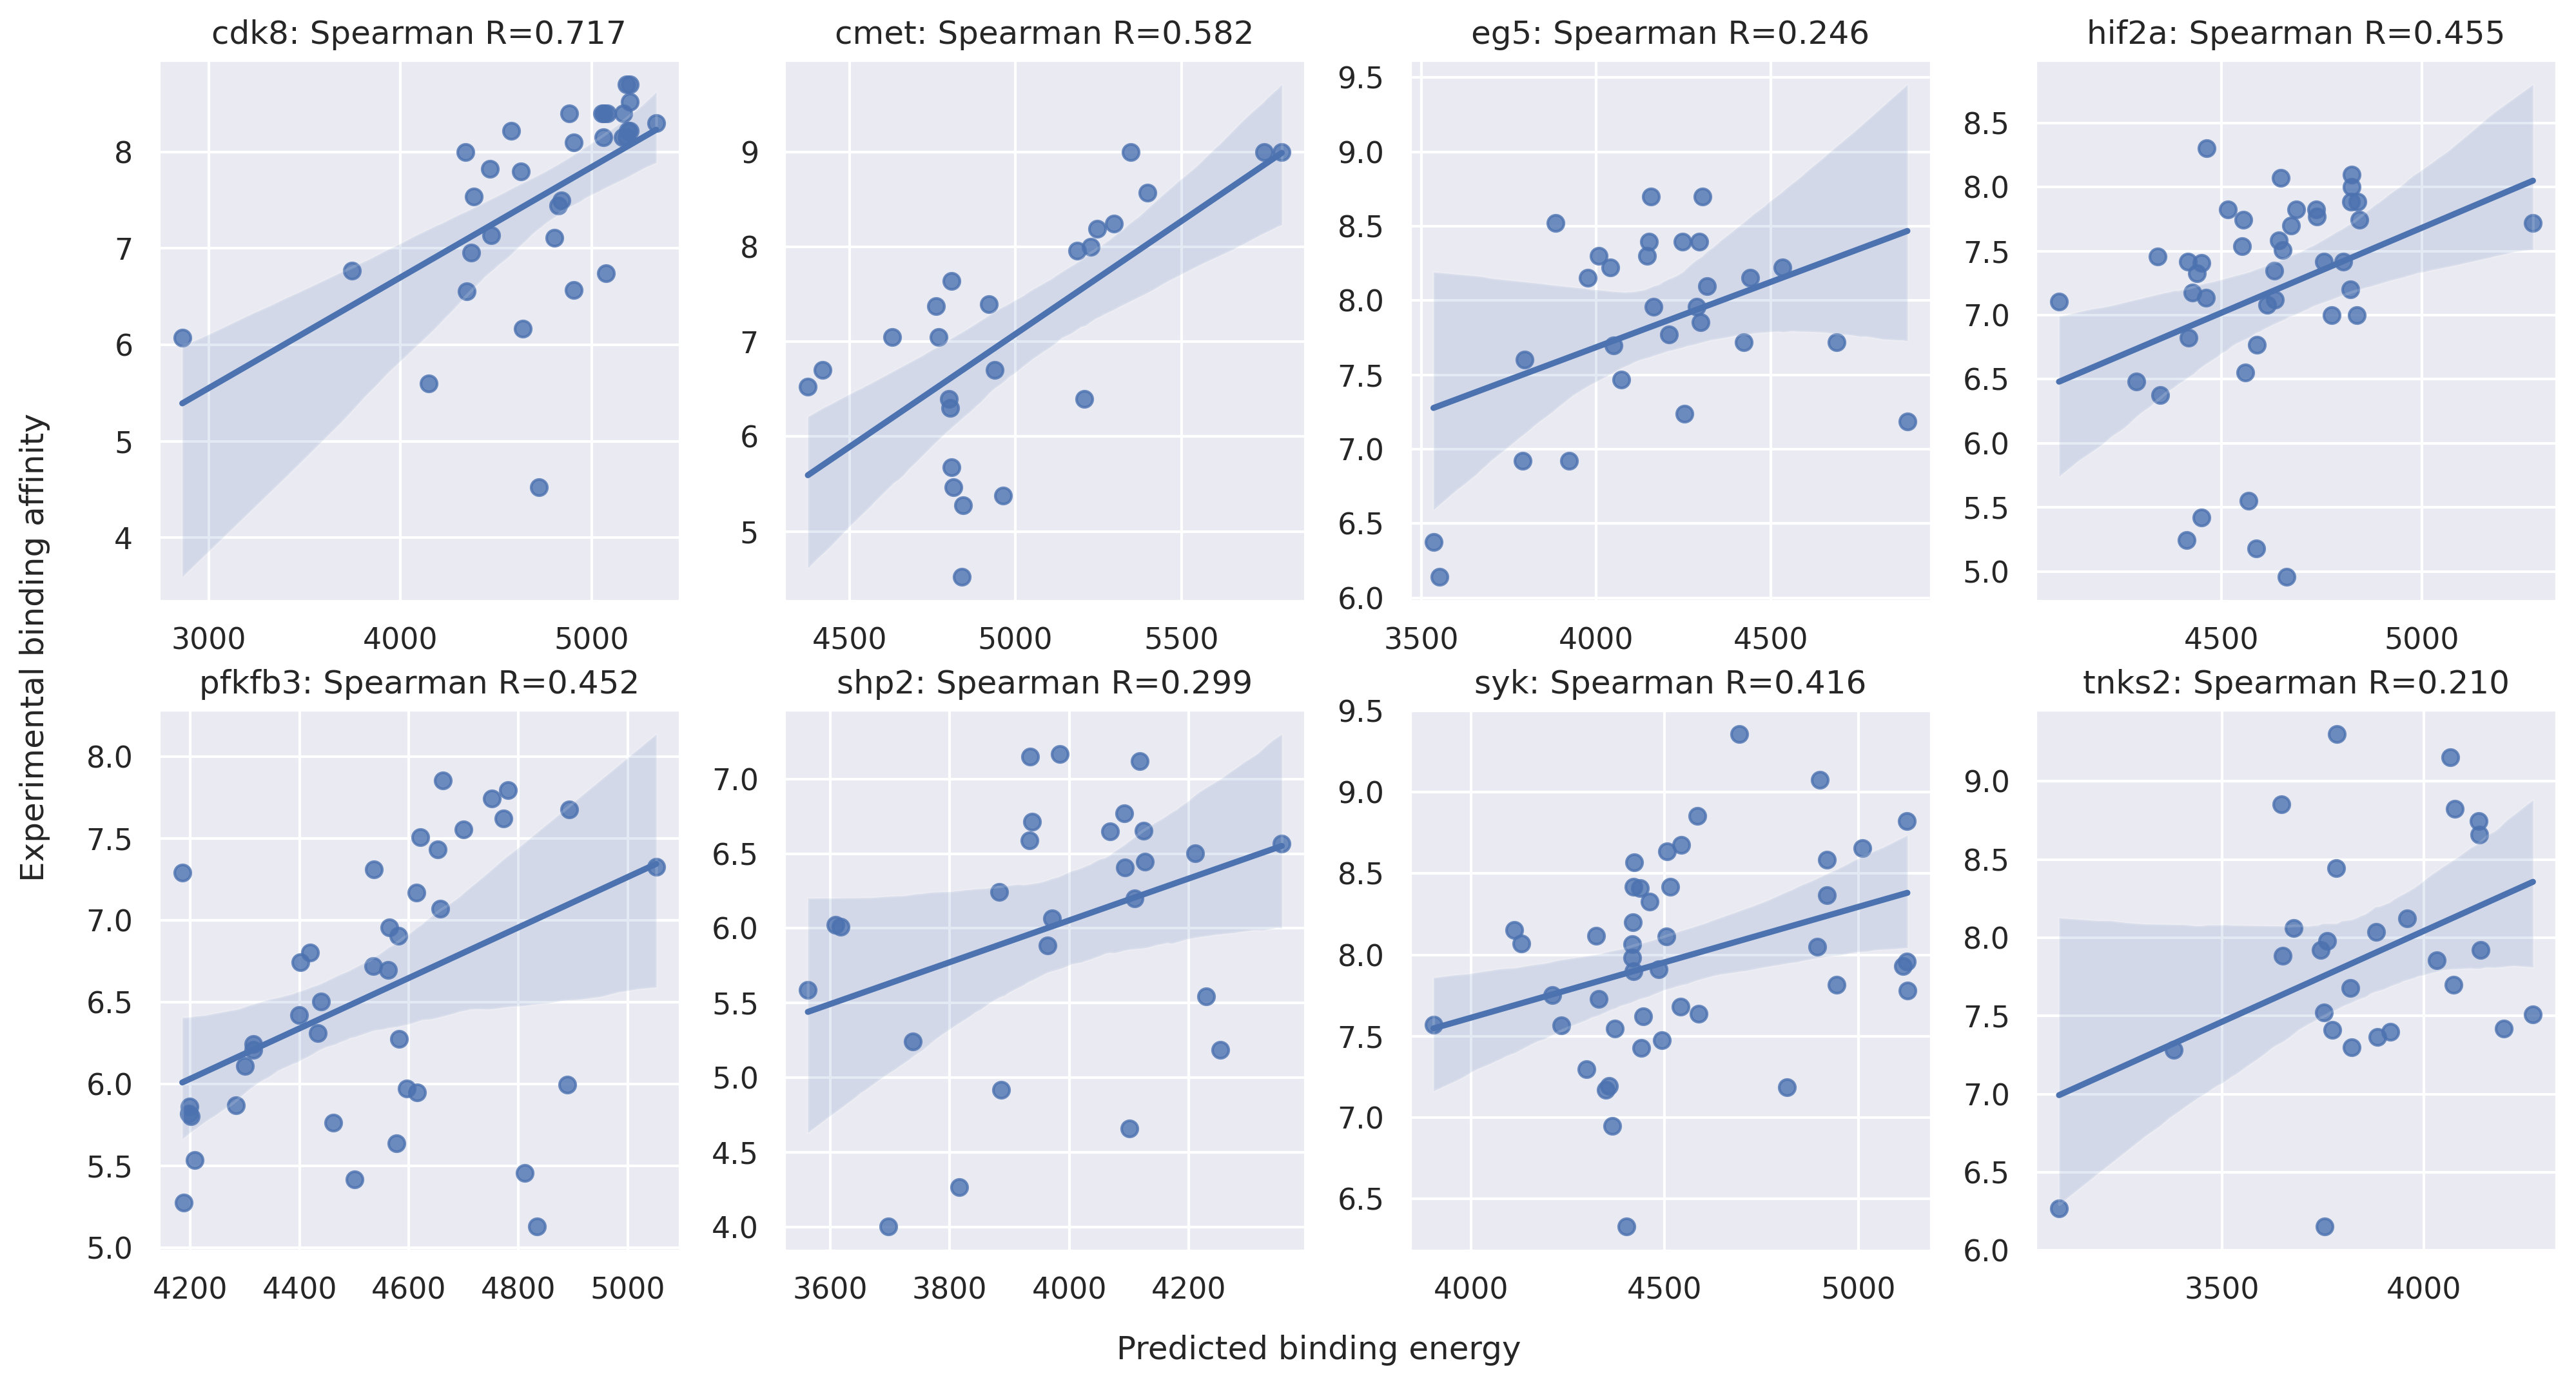

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
fig.text(0.5, 0.04, 'Predicted binding energy', ha='center')
fig.text(0.08, 0.5, 'Experimental binding affinity', va='center', rotation='vertical')
for i,pdb in enumerate(score.keys()):
    i, j = i // 4, i % 4
    sns.regplot(x=score[pdb], y=label[pdb], ax=axes[i,j])
    corr = scipy.stats.spearmanr(score[pdb], label[pdb])[0]
    axes[i,j].set_title(f'{pdb}: Spearman R={corr:.3f}')

### Antibody-Antigen Binding

In [12]:
def sabdab_evaluate(model, data, embedding, args):
    model.eval()
    pred, label = [], []
    for ab in tqdm(data):
        binder, target = AntibodyDataset.make_local_batch([ab], embedding, args)
        score = model.predict(binder, target)
        pred.append(-1.0 * score.item())
        label.append(ab['affinity'])
    return scipy.stats.spearmanr(pred, label)[0], pred, label

In our NeurIPS and biorxiv paper, we evaluate on two test sets:
* The first test set is from SAbDab. It has 566 antibody-antigen complexes with binding affinity labels
* The second test set is from . It has 424 HER2-trastuzumab variants (CDR3 mutation) with binding affinity labels

In [13]:
test_sabdab = AntibodyDataset("data/antibody/test_sabdab.jsonl", cdr_type='123456', epitope_size=50)
test_HER2 = AntibodyDataset("data/antibody/test_HER2.jsonl", cdr_type='123456', epitope_size=50)

100%|██████████| 422/422 [00:08<00:00, 50.60it/s]


In [14]:
embedding = load_esm_embedding(test_sabdab.data + test_HER2.data, ['antibody_seq', 'antigen_seq'])

100%|██████████| 513/513 [01:00<00:00,  8.51it/s]


In [15]:
model_ckpt, opt_ckpt, model_args = torch.load("ckpts/model.antibody.allatom")
model = AllAtomEnergyModel(model_args).cuda()
model.load_state_dict(model_ckpt)
model.eval()

AllAtomEnergyModel(
  (mse_loss): MSELoss()
  (encoder): AllAtomEncoder(
    (W_bind): Linear(in_features=2560, out_features=256, bias=True)
    (W_tgt): Linear(in_features=2560, out_features=256, bias=True)
    (A_bind): Embedding(63, 256)
    (A_tgt): Embedding(63, 256)
    (encoder): SRUpp(
      (rnn_lst): ModuleList(
        (0): SRUppCell(515, 128, dropout=0.1, bidirectional=True, highway_bias=-2.0,
          transform_module=SRUppAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (linear1): Linear(in_features=515, out_features=128, bias=False)
          (linear2): Linear(in_features=128, out_features=256, bias=False)
          (linear3): Linear(in_features=128, out_features=1024, bias=False)
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        )
        (1): SRUppCell(256, 128, dropout=0.1, bidirectional=True, highway_bias=-2.0,
          transform_module=SRUppAttention(
          (dropout): Dropout(p=0.1, inplace=F

In [16]:
test_corr, pred, label = sabdab_evaluate(model, test_sabdab, embedding, model_args)

100%|██████████| 566/566 [00:06<00:00, 91.59it/s]


Text(0.5, 1.0, 'SAbDab test correlation: Spearman R = 0.3605')

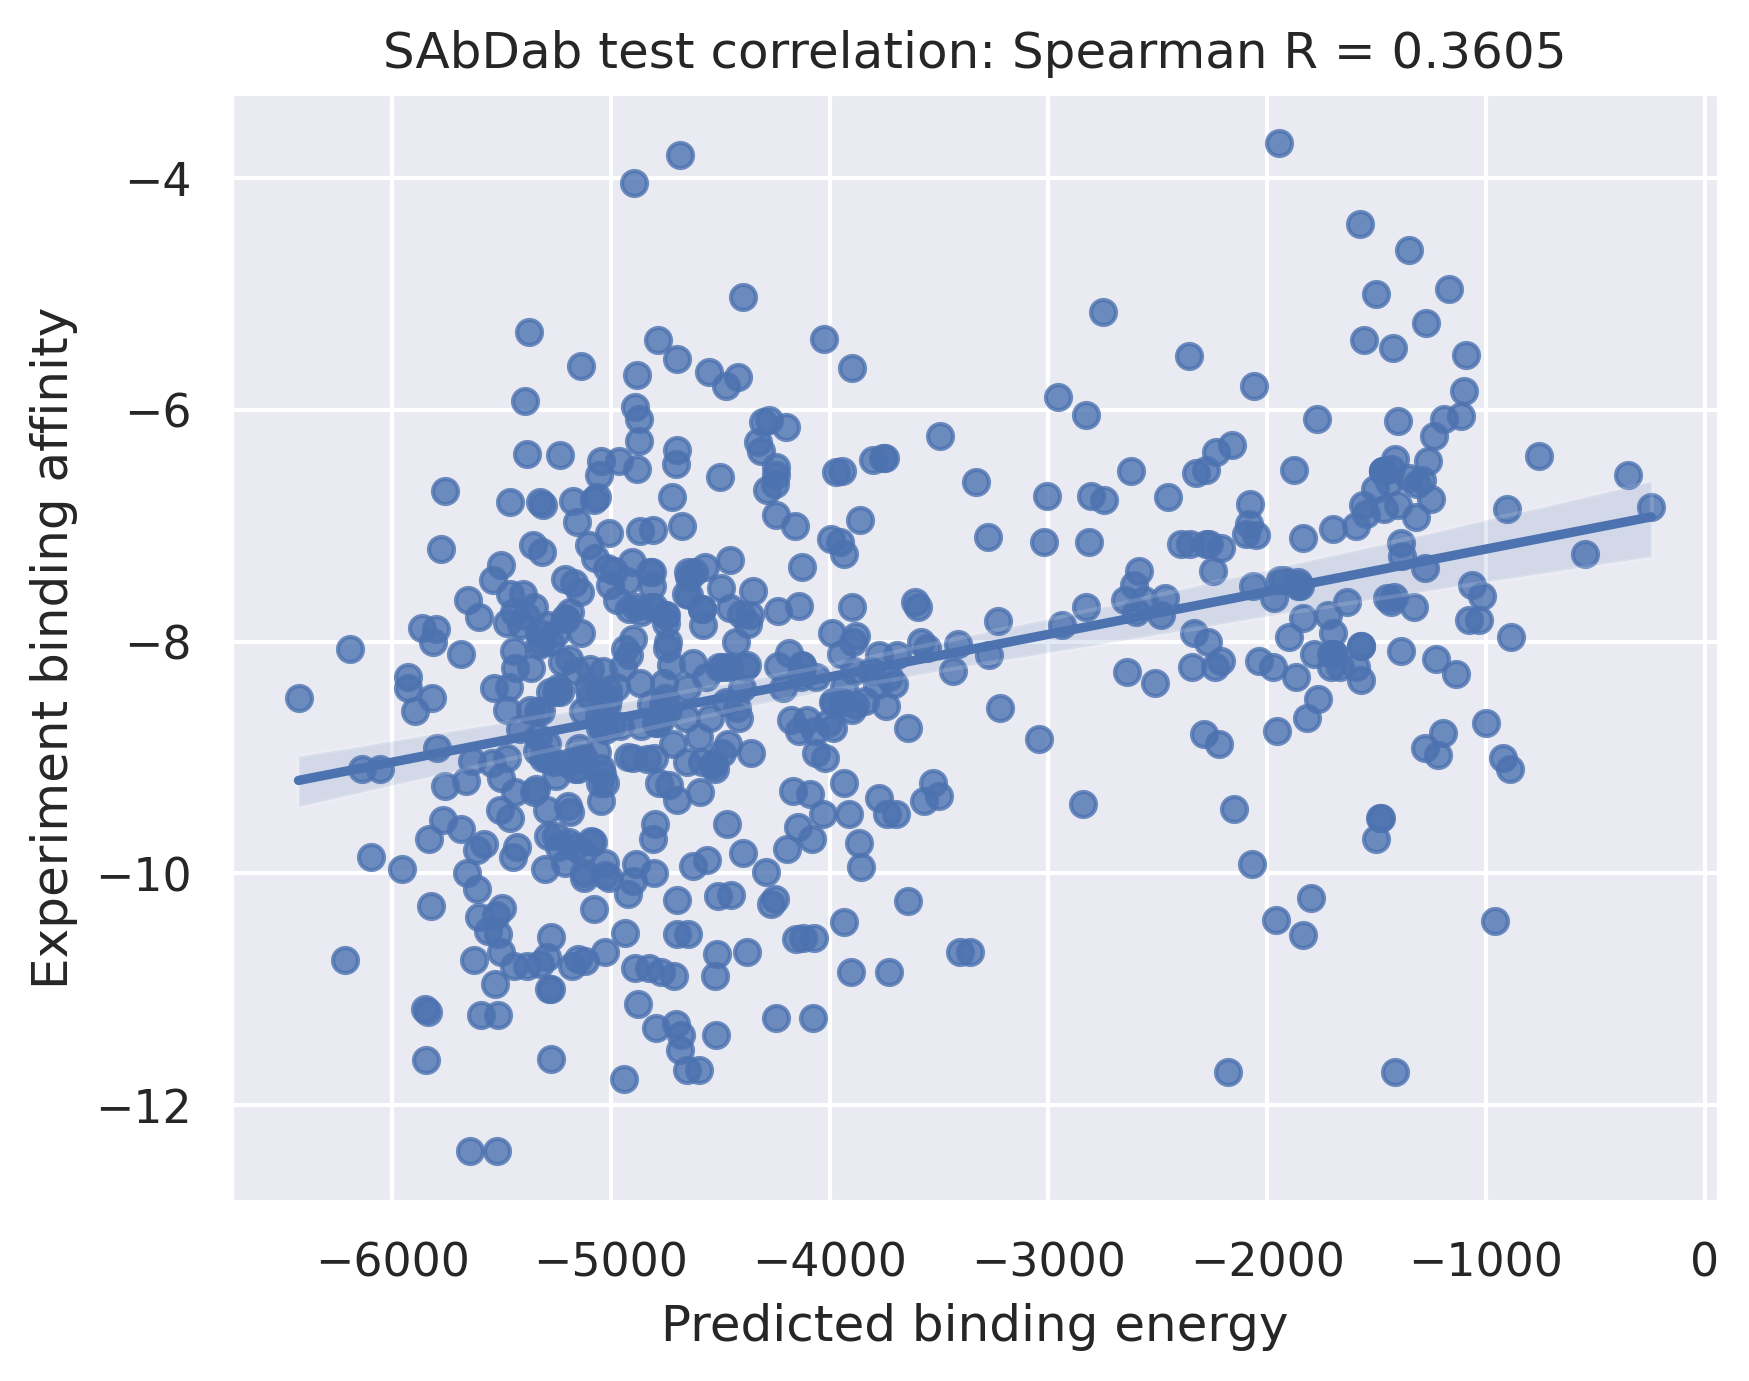

In [17]:
sns.regplot(x=pred, y=label)
plt.xlabel('Predicted binding energy')
plt.ylabel('Experiment binding affinity')
plt.title(f'SAbDab test correlation: Spearman R = {test_corr:.4f}')

100%|██████████| 422/422 [00:03<00:00, 105.75it/s]


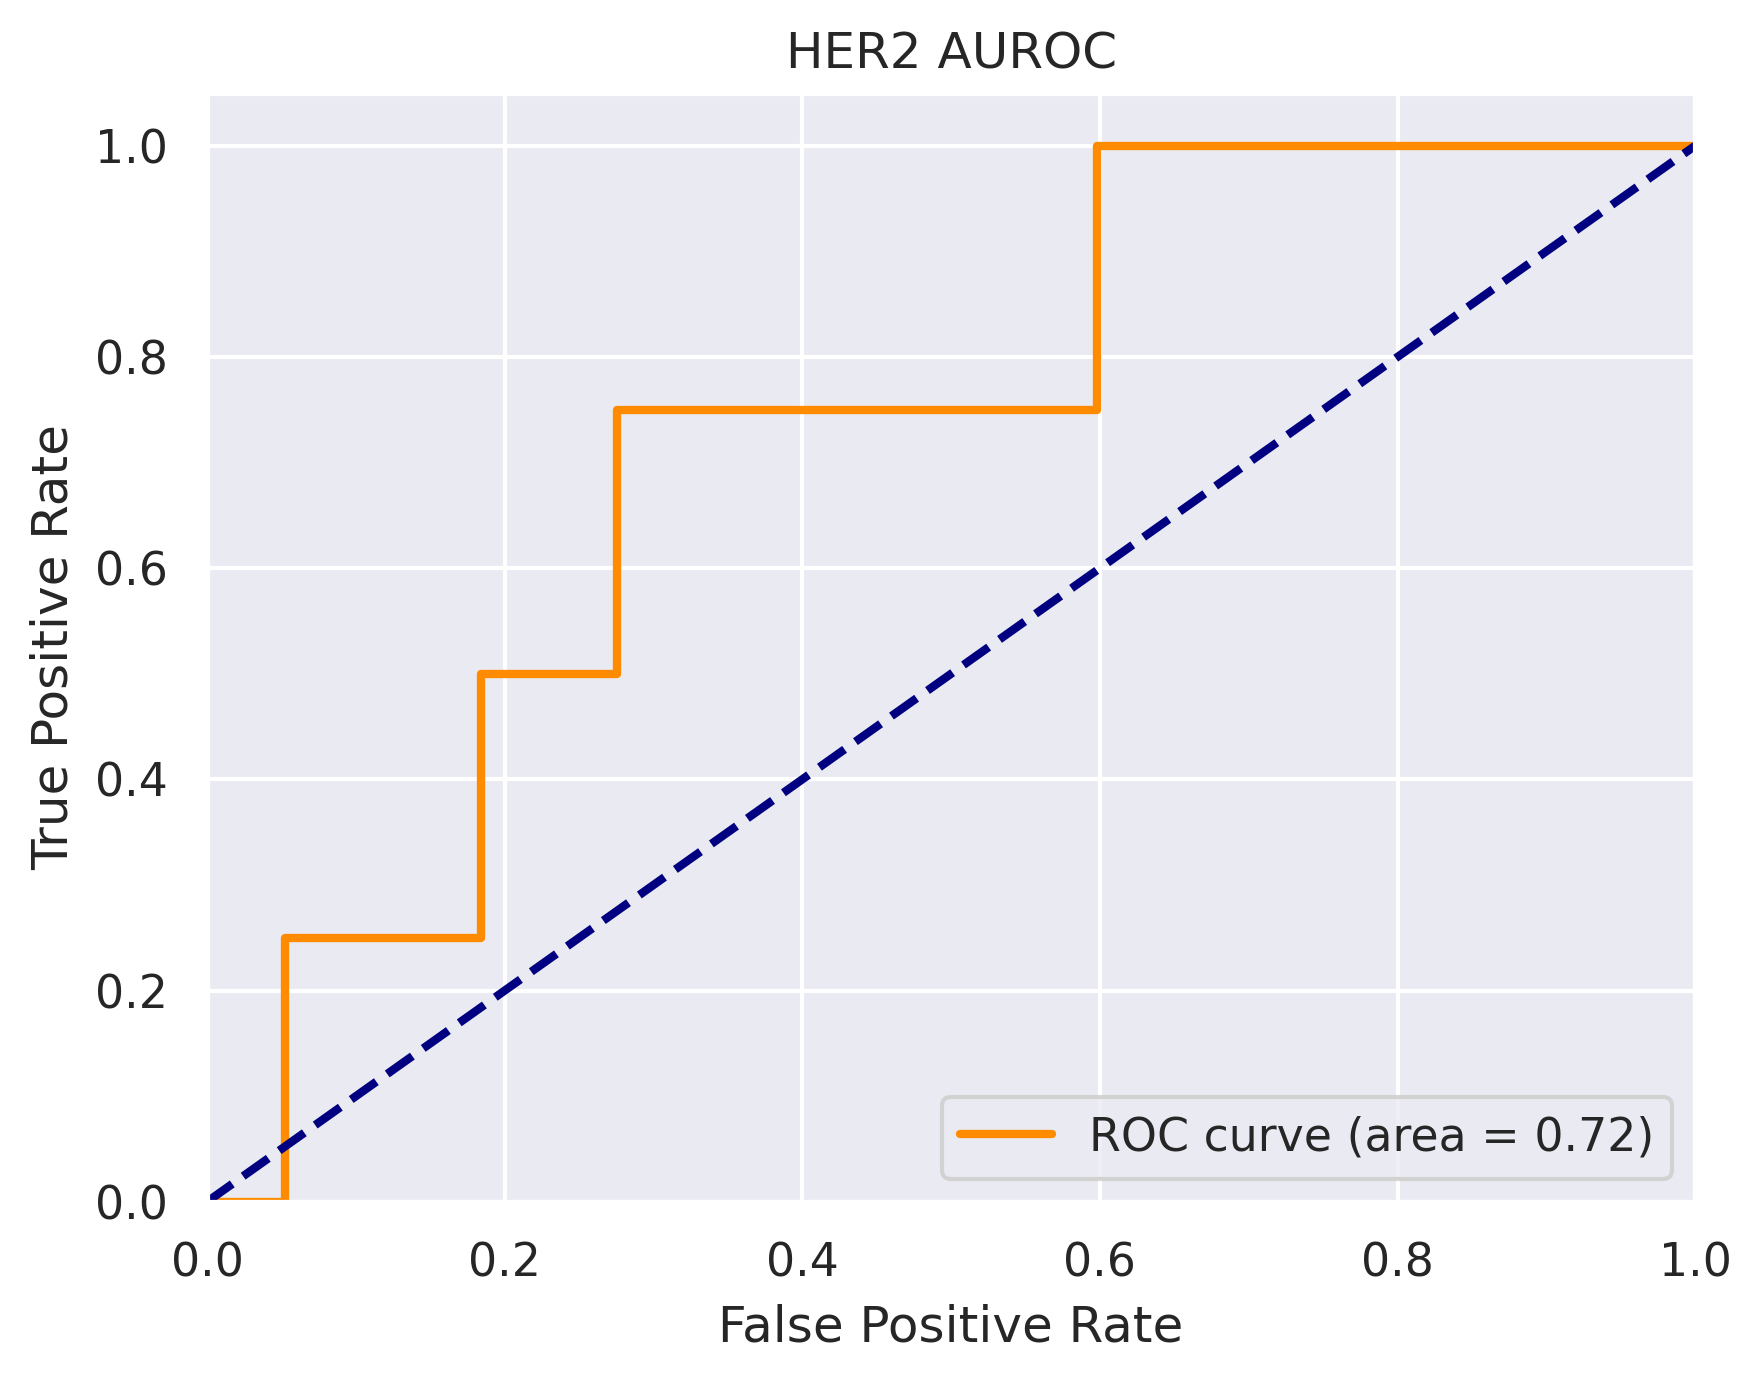

In [18]:
pred, label = [], []
for ab in tqdm(test_HER2):
    binder, target = AntibodyDataset.make_local_batch([ab], embedding, model_args)
    score = model.predict(binder, target)
    pred.append(score.item())
    label.append(int(ab['affinity'] < -8.7))  # better than wildtype trastuzumab binding affinity 

fpr, tpr, _ = roc_curve(label, pred)
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc_score(label, pred),
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("HER2 AUROC")
plt.legend(loc="lower right")
plt.show()

#### SKEMPI Results

In [19]:
test_data = ProteinDataset("data/skempi/skempi_all.pkl", 50)
embedding = load_esm_embedding(test_data.data, ['binder_full', 'target_full'])

100%|██████████| 6075/6075 [00:08<00:00, 750.85it/s] 


In [20]:
model_ckpt, _, model_args = torch.load("ckpts/model.skempi.allatom")
model = AllAtomEnergyModel(model_args).cuda()
model.load_state_dict(model_ckpt)
model.eval()

AllAtomEnergyModel(
  (mse_loss): MSELoss()
  (encoder): AllAtomEncoder(
    (W_bind): Linear(in_features=2560, out_features=256, bias=True)
    (W_tgt): Linear(in_features=2560, out_features=256, bias=True)
    (A_bind): Embedding(63, 256)
    (A_tgt): Embedding(63, 256)
    (encoder): SRUpp(
      (rnn_lst): ModuleList(
        (0): SRUppCell(515, 128, bidirectional=True, highway_bias=-2.0,
          transform_module=SRUppAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (linear1): Linear(in_features=515, out_features=128, bias=False)
          (linear2): Linear(in_features=128, out_features=256, bias=False)
          (linear3): Linear(in_features=128, out_features=1024, bias=False)
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        )
      )
    )
  )
  (W_o): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): SiLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
  (

In [21]:
with torch.no_grad():
    wt_map = {}
    pred, label = [], []
    for entry in test_data.data:
        pdb, mutation, ddg = entry['pdb']
        if len(mutation) == 0:
            binder, target = ProteinDataset.make_local_batch([entry], embedding, model_args, 'binder', 'target')
            wt_map[pdb] = model.predict(binder, target) + model.predict(target, binder)

    for entry in test_data.data:
        pdb, mutation, ddg = entry['pdb']
        if len(mutation) > 0:
            binder, target = ProteinDataset.make_local_batch([entry], embedding, model_args, 'binder', 'target')
            score = model.predict(binder, target) + model.predict(target, binder)
            score = score - wt_map[pdb]
            pred.append(-1.0 * score.item())
            label.append(ddg)

Text(0.5, 1.0, 'SKEMPI test correlation: Spearman R = 0.4218')

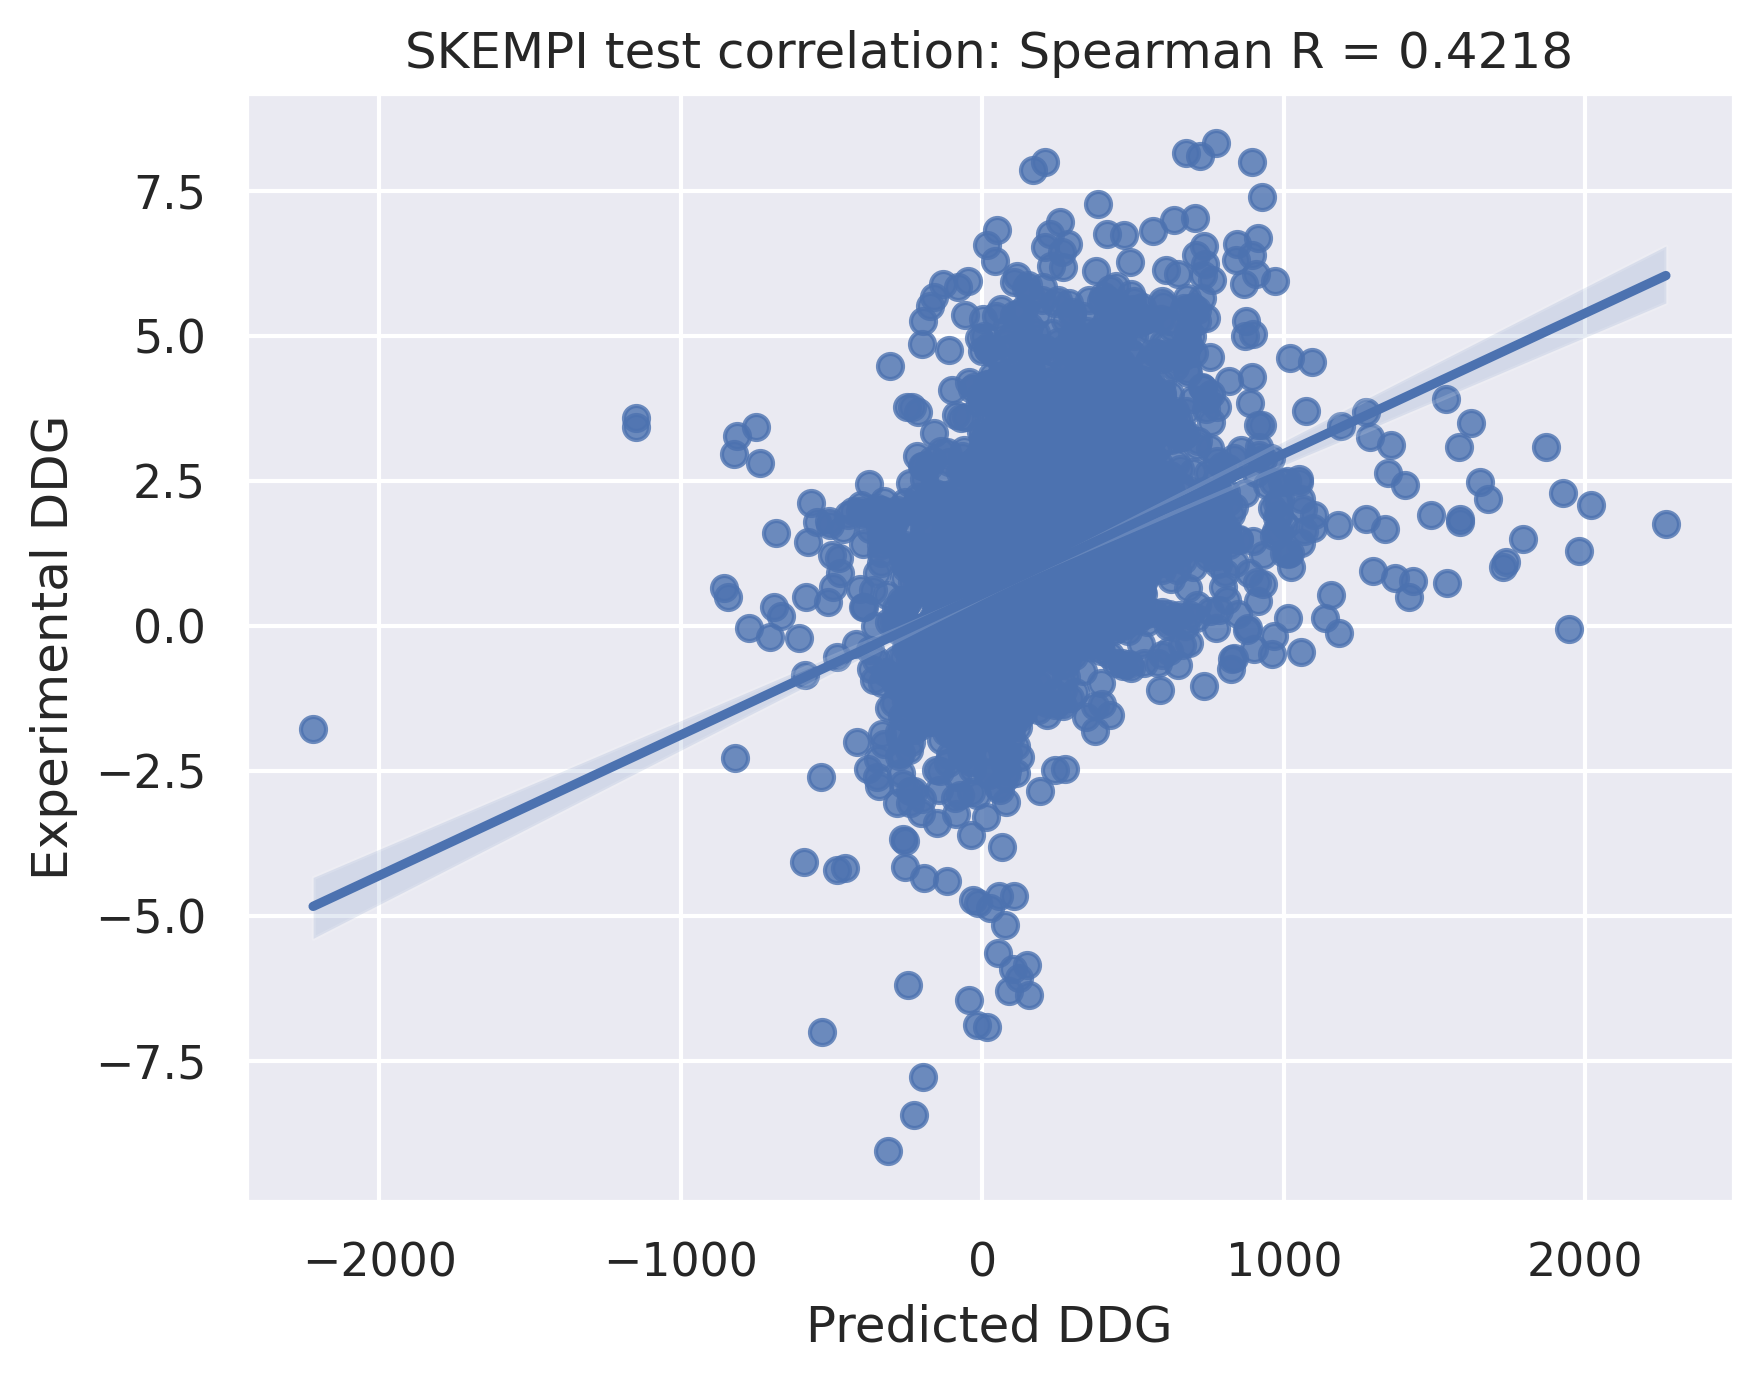

In [22]:
test_corr = scipy.stats.spearmanr(pred, label)[0]
sns.regplot(x=pred, y=label)
plt.xlabel('Predicted DDG')
plt.ylabel('Experimental DDG')
plt.title(f'SKEMPI test correlation: Spearman R = {test_corr:.4f}')

### Ligand virtual screening

In [3]:
torch.cuda.set_device(0)
fn = 'ckpts/model.recA'
model_ckpt, opt_ckpt, model_args = torch.load(fn)
model = DrugAllAtomEnergyModel(model_args).cuda()
model.load_state_dict(model_ckpt)
model.eval()

KeyboardInterrupt: 

In [2]:
sdf_list = sorted(glob.glob('data/recA/FABind/*.sdf'))
result, _ = model.virtual_screen('data/recA/3cmt.pdb', sdf_list, batch_size=1)
pd.DataFrame(result)

NameError: name 'model' is not defined

In [2]:
torch.cuda.set_device(1)
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

with open('data/recA/recA.csv') as f:
    label_map = {}
    for line in f.readlines()[1:]:
        smiles, label = line.split(',')
        smiles = Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=False)
        label = int(label)
        label_map[smiles] = label

embedding = None
for fn in glob.glob('/home/wjin/bindenergy/ckpts/drug/seed*/full-d*/model.ckpt.*'):
    model_ckpt, opt_ckpt, model_args = torch.load(fn)
    model = DrugAllAtomEnergyModel(model_args).cuda()
    model.load_state_dict(model_ckpt)
    model.eval()
    sdf_list = sorted(glob.glob('data/recA/FABind/*.sdf'))
    result, _ = model.virtual_screen('data/recA/3cmt.pdb', sdf_list, batch_size=1, embedding=embedding)
    x, y = [], []
    for _,smiles,score in result:
        smiles = Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=False)
        if smiles in label_map:
            x.append(score)
            y.append(label_map[smiles])
    print(fn, roc_auc_score(y, x))

100%|██████████| 174/174 [00:02<00:00, 72.04it/s]
/home/wjin/bindenergy/bindenergy/models/frame.py:21: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion.
L, _ = torch.symeig(A, upper=upper)
should be replaced with
L = torch.linalg.eigvalsh(A, UPLO='U' if upper else 'L')
and
L, V = torch.symeig(A, eigenvectors=True)
should be replaced with
L, V = torch.linalg.eigh(A, UPLO='U' if upper else 'L') (Triggered internally at /opt/conda/conda-bld/pytorch_1670525552411/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2794.)
  _, V = torch.symeig(C.detach(), True)  # [B,3,3]


/home/wjin/bindenergy/ckpts/drug/seed9/full-d1/model.ckpt.7 0.4351949420442571


100%|██████████| 174/174 [00:02<00:00, 68.10it/s]


/home/wjin/bindenergy/ckpts/drug/seed9/full-d1/model.ckpt.5 0.446259220231823


100%|██████████| 174/174 [00:02<00:00, 77.77it/s]


/home/wjin/bindenergy/ckpts/drug/seed9/full-d1/model.ckpt.4 0.4694415173867229


100%|██████████| 174/174 [00:02<00:00, 76.72it/s]


/home/wjin/bindenergy/ckpts/drug/seed9/full-d1/model.ckpt.1 0.5429399367755532


100%|██████████| 174/174 [00:02<00:00, 74.29it/s]


/home/wjin/bindenergy/ckpts/drug/seed9/full-d1/model.ckpt.8 0.4607481559536354


100%|██████████| 174/174 [00:02<00:00, 76.02it/s]


/home/wjin/bindenergy/ckpts/drug/seed9/full-d1/model.ckpt.9 0.5445205479452054


100%|██████████| 174/174 [00:01<00:00, 121.15it/s]


/home/wjin/bindenergy/ckpts/drug/seed9/full-d1/model.ckpt.6 0.5079030558482613


100%|██████████| 174/174 [00:01<00:00, 96.19it/s] 


/home/wjin/bindenergy/ckpts/drug/seed9/full-d1/model.ckpt.0 0.49104320337197055


100%|██████████| 174/174 [00:02<00:00, 85.35it/s]


/home/wjin/bindenergy/ckpts/drug/seed9/full-d1/model.ckpt.3 0.5202845100105374


100%|██████████| 174/174 [00:02<00:00, 75.65it/s]


/home/wjin/bindenergy/ckpts/drug/seed9/full-d1/model.ckpt.2 0.49552160168598525


100%|██████████| 174/174 [00:02<00:00, 85.53it/s]


/home/wjin/bindenergy/ckpts/drug/seed9/full-d2/model.ckpt.7 0.47839831401475236


100%|██████████| 174/174 [00:02<00:00, 75.50it/s]


/home/wjin/bindenergy/ckpts/drug/seed9/full-d2/model.ckpt.5 0.4794520547945206


100%|██████████| 174/174 [00:02<00:00, 85.40it/s]


/home/wjin/bindenergy/ckpts/drug/seed9/full-d2/model.ckpt.4 0.45864067439409906


100%|██████████| 174/174 [00:02<00:00, 75.19it/s]


/home/wjin/bindenergy/ckpts/drug/seed9/full-d2/model.ckpt.1 0.4338777660695469


100%|██████████| 174/174 [00:02<00:00, 86.31it/s]


/home/wjin/bindenergy/ckpts/drug/seed9/full-d2/model.ckpt.8 0.4733930453108535


100%|██████████| 174/174 [00:02<00:00, 75.80it/s]


/home/wjin/bindenergy/ckpts/drug/seed9/full-d2/model.ckpt.9 0.4436248682824026


100%|██████████| 174/174 [00:02<00:00, 85.50it/s]


/home/wjin/bindenergy/ckpts/drug/seed9/full-d2/model.ckpt.6 0.4797154899894626


100%|██████████| 174/174 [00:02<00:00, 76.00it/s]


/home/wjin/bindenergy/ckpts/drug/seed9/full-d2/model.ckpt.0 0.6475237091675448


100%|██████████| 174/174 [00:02<00:00, 84.09it/s]


/home/wjin/bindenergy/ckpts/drug/seed9/full-d2/model.ckpt.3 0.4549525816649105


100%|██████████| 174/174 [00:02<00:00, 75.69it/s]


/home/wjin/bindenergy/ckpts/drug/seed9/full-d2/model.ckpt.2 0.43203371970495263


100%|██████████| 174/174 [00:02<00:00, 80.53it/s]


/home/wjin/bindenergy/ckpts/drug/seed9/full-d3/model.ckpt.7 0.4873551106427819


100%|██████████| 174/174 [00:02<00:00, 85.50it/s]


/home/wjin/bindenergy/ckpts/drug/seed9/full-d3/model.ckpt.5 0.41938883034773444


100%|██████████| 174/174 [00:02<00:00, 59.09it/s]


/home/wjin/bindenergy/ckpts/drug/seed9/full-d3/model.ckpt.4 0.42887249736564803


100%|██████████| 174/174 [00:02<00:00, 80.59it/s]


/home/wjin/bindenergy/ckpts/drug/seed9/full-d3/model.ckpt.1 0.5690200210748155


100%|██████████| 174/174 [00:02<00:00, 75.63it/s]


/home/wjin/bindenergy/ckpts/drug/seed9/full-d3/model.ckpt.8 0.5094836670179137


100%|██████████| 174/174 [00:02<00:00, 84.81it/s]


/home/wjin/bindenergy/ckpts/drug/seed9/full-d3/model.ckpt.9 0.493940990516333


100%|██████████| 174/174 [00:02<00:00, 74.84it/s]


/home/wjin/bindenergy/ckpts/drug/seed9/full-d3/model.ckpt.6 0.4373024236037935


100%|██████████| 174/174 [00:02<00:00, 85.12it/s]


/home/wjin/bindenergy/ckpts/drug/seed9/full-d3/model.ckpt.0 0.20284510010537407


100%|██████████| 174/174 [00:02<00:00, 74.99it/s]


/home/wjin/bindenergy/ckpts/drug/seed9/full-d3/model.ckpt.3 0.4017386722866175


100%|██████████| 174/174 [00:02<00:00, 85.34it/s]


/home/wjin/bindenergy/ckpts/drug/seed9/full-d3/model.ckpt.2 0.5005268703898841


100%|██████████| 174/174 [00:02<00:00, 75.70it/s]


/home/wjin/bindenergy/ckpts/drug/seed8/full-d1/model.ckpt.7 0.40463645943098003


100%|██████████| 174/174 [00:02<00:00, 85.53it/s]


/home/wjin/bindenergy/ckpts/drug/seed8/full-d1/model.ckpt.5 0.5142255005268704


100%|██████████| 174/174 [00:02<00:00, 75.61it/s]


/home/wjin/bindenergy/ckpts/drug/seed8/full-d1/model.ckpt.4 0.4694415173867229


100%|██████████| 174/174 [00:02<00:00, 85.54it/s]


/home/wjin/bindenergy/ckpts/drug/seed8/full-d1/model.ckpt.1 0.48524762908324554


100%|██████████| 174/174 [00:02<00:00, 75.45it/s]


/home/wjin/bindenergy/ckpts/drug/seed8/full-d1/model.ckpt.8 0.53609062170706


100%|██████████| 174/174 [00:02<00:00, 85.51it/s]


/home/wjin/bindenergy/ckpts/drug/seed8/full-d1/model.ckpt.9 0.5163329820864068


100%|██████████| 174/174 [00:02<00:00, 70.35it/s]


/home/wjin/bindenergy/ckpts/drug/seed8/full-d1/model.ckpt.6 0.4931506849315068


100%|██████████| 174/174 [00:02<00:00, 85.31it/s]


/home/wjin/bindenergy/ckpts/drug/seed8/full-d1/model.ckpt.0 0.5521601685985247


100%|██████████| 174/174 [00:02<00:00, 75.64it/s]


/home/wjin/bindenergy/ckpts/drug/seed8/full-d1/model.ckpt.3 0.517650158061117


100%|██████████| 174/174 [00:01<00:00, 95.71it/s] 


/home/wjin/bindenergy/ckpts/drug/seed8/full-d1/model.ckpt.2 0.5516332982086407


100%|██████████| 174/174 [00:02<00:00, 78.69it/s]


/home/wjin/bindenergy/ckpts/drug/seed8/full-d2/model.ckpt.7 0.4815595363540569


100%|██████████| 174/174 [00:02<00:00, 85.16it/s]


/home/wjin/bindenergy/ckpts/drug/seed8/full-d2/model.ckpt.5 0.5150158061116965


100%|██████████| 174/174 [00:02<00:00, 84.31it/s]


/home/wjin/bindenergy/ckpts/drug/seed8/full-d2/model.ckpt.4 0.505532139093783


100%|██████████| 174/174 [00:02<00:00, 80.15it/s]


/home/wjin/bindenergy/ckpts/drug/seed8/full-d2/model.ckpt.1 0.5131717597471022


100%|██████████| 174/174 [00:02<00:00, 79.20it/s]


/home/wjin/bindenergy/ckpts/drug/seed8/full-d2/model.ckpt.8 0.48024236037934676


100%|██████████| 174/174 [00:02<00:00, 79.79it/s]


/home/wjin/bindenergy/ckpts/drug/seed8/full-d2/model.ckpt.9 0.4831401475237092


100%|██████████| 174/174 [00:02<00:00, 79.72it/s]


/home/wjin/bindenergy/ckpts/drug/seed8/full-d2/model.ckpt.6 0.48182297154899895


100%|██████████| 174/174 [00:02<00:00, 84.73it/s]


/home/wjin/bindenergy/ckpts/drug/seed8/full-d2/model.ckpt.0 0.7373551106427819


100%|██████████| 174/174 [00:02<00:00, 80.05it/s]


/home/wjin/bindenergy/ckpts/drug/seed8/full-d2/model.ckpt.3 0.5134351949420444


100%|██████████| 174/174 [00:02<00:00, 85.67it/s]


/home/wjin/bindenergy/ckpts/drug/seed8/full-d2/model.ckpt.2 0.4823498419388831


100%|██████████| 174/174 [00:02<00:00, 74.89it/s]


/home/wjin/bindenergy/ckpts/drug/seed8/full-d3/model.ckpt.7 0.48630136986301375


100%|██████████| 174/174 [00:02<00:00, 80.11it/s]


/home/wjin/bindenergy/ckpts/drug/seed8/full-d3/model.ckpt.5 0.48472075869336145


100%|██████████| 174/174 [00:02<00:00, 85.47it/s]


/home/wjin/bindenergy/ckpts/drug/seed8/full-d3/model.ckpt.4 0.48208640674394104


100%|██████████| 174/174 [00:02<00:00, 74.75it/s]


/home/wjin/bindenergy/ckpts/drug/seed8/full-d3/model.ckpt.1 0.5031612223393045


100%|██████████| 174/174 [00:02<00:00, 85.51it/s]


/home/wjin/bindenergy/ckpts/drug/seed8/full-d3/model.ckpt.8 0.5213382507903055


100%|██████████| 174/174 [00:02<00:00, 74.13it/s]


/home/wjin/bindenergy/ckpts/drug/seed8/full-d3/model.ckpt.9 0.511064278187566


100%|██████████| 174/174 [00:02<00:00, 85.92it/s]


/home/wjin/bindenergy/ckpts/drug/seed8/full-d3/model.ckpt.6 0.48182297154899895


100%|██████████| 174/174 [00:02<00:00, 75.28it/s]


/home/wjin/bindenergy/ckpts/drug/seed8/full-d3/model.ckpt.0 0.5453108535300316


100%|██████████| 174/174 [00:02<00:00, 84.67it/s]


/home/wjin/bindenergy/ckpts/drug/seed8/full-d3/model.ckpt.3 0.48287671232876717


100%|██████████| 174/174 [00:02<00:00, 74.96it/s]


/home/wjin/bindenergy/ckpts/drug/seed8/full-d3/model.ckpt.2 0.49209694415173866


100%|██████████| 174/174 [00:02<00:00, 85.22it/s]


/home/wjin/bindenergy/ckpts/drug/seed5/full-d1/model.ckpt.7 0.5150158061116965


100%|██████████| 174/174 [00:02<00:00, 84.97it/s]


/home/wjin/bindenergy/ckpts/drug/seed5/full-d1/model.ckpt.5 0.5073761854583773


100%|██████████| 174/174 [00:02<00:00, 79.49it/s]


/home/wjin/bindenergy/ckpts/drug/seed5/full-d1/model.ckpt.4 0.517650158061117


100%|██████████| 174/174 [00:02<00:00, 85.04it/s]


/home/wjin/bindenergy/ckpts/drug/seed5/full-d1/model.ckpt.1 0.5302950474183351


100%|██████████| 174/174 [00:02<00:00, 79.70it/s]


/home/wjin/bindenergy/ckpts/drug/seed5/full-d1/model.ckpt.8 0.5147523709167545


100%|██████████| 174/174 [00:02<00:00, 85.24it/s]


/home/wjin/bindenergy/ckpts/drug/seed5/full-d1/model.ckpt.9 0.5142255005268704


100%|██████████| 174/174 [00:02<00:00, 75.42it/s]


/home/wjin/bindenergy/ckpts/drug/seed5/full-d1/model.ckpt.6 0.48024236037934664


100%|██████████| 174/174 [00:02<00:00, 85.89it/s]


/home/wjin/bindenergy/ckpts/drug/seed5/full-d1/model.ckpt.0 0.48129610115911486


100%|██████████| 174/174 [00:02<00:00, 73.99it/s]


/home/wjin/bindenergy/ckpts/drug/seed5/full-d1/model.ckpt.3 0.5263435194942045


100%|██████████| 174/174 [00:02<00:00, 85.92it/s]


/home/wjin/bindenergy/ckpts/drug/seed5/full-d1/model.ckpt.2 0.4852476290832455


100%|██████████| 174/174 [00:02<00:00, 79.47it/s]


/home/wjin/bindenergy/ckpts/drug/seed5/full-d2/model.ckpt.7 0.47708113804004215


100%|██████████| 174/174 [00:02<00:00, 74.87it/s]


/home/wjin/bindenergy/ckpts/drug/seed5/full-d2/model.ckpt.5 0.5318756585879874


100%|██████████| 174/174 [00:01<00:00, 113.37it/s]


/home/wjin/bindenergy/ckpts/drug/seed5/full-d2/model.ckpt.4 0.5150158061116965


100%|██████████| 174/174 [00:02<00:00, 74.86it/s]


/home/wjin/bindenergy/ckpts/drug/seed5/full-d2/model.ckpt.1 0.48050579557428874


100%|██████████| 174/174 [00:02<00:00, 85.29it/s]


/home/wjin/bindenergy/ckpts/drug/seed5/full-d2/model.ckpt.8 0.5168598524762908


100%|██████████| 174/174 [00:02<00:00, 75.16it/s]


/home/wjin/bindenergy/ckpts/drug/seed5/full-d2/model.ckpt.9 0.49578503688092734


100%|██████████| 174/174 [00:02<00:00, 85.41it/s]


/home/wjin/bindenergy/ckpts/drug/seed5/full-d2/model.ckpt.6 0.47444678609062174


100%|██████████| 174/174 [00:02<00:00, 73.30it/s]


/home/wjin/bindenergy/ckpts/drug/seed5/full-d2/model.ckpt.0 0.7107481559536354


100%|██████████| 174/174 [00:02<00:00, 85.69it/s]


/home/wjin/bindenergy/ckpts/drug/seed5/full-d2/model.ckpt.3 0.49077976817702845


100%|██████████| 174/174 [00:02<00:00, 72.71it/s]


/home/wjin/bindenergy/ckpts/drug/seed5/full-d2/model.ckpt.2 0.464172813487882


100%|██████████| 174/174 [00:02<00:00, 79.04it/s]


/home/wjin/bindenergy/ckpts/drug/seed5/full-d3/model.ckpt.7 0.48630136986301375


100%|██████████| 174/174 [00:05<00:00, 32.64it/s]


/home/wjin/bindenergy/ckpts/drug/seed5/full-d3/model.ckpt.5 0.48893572181243417


100%|██████████| 174/174 [00:05<00:00, 31.35it/s]


/home/wjin/bindenergy/ckpts/drug/seed5/full-d3/model.ckpt.4 0.4897260273972603


100%|██████████| 174/174 [00:05<00:00, 31.62it/s]


/home/wjin/bindenergy/ckpts/drug/seed5/full-d3/model.ckpt.1 0.4870916754478398


100%|██████████| 174/174 [00:07<00:00, 23.44it/s]


/home/wjin/bindenergy/ckpts/drug/seed5/full-d3/model.ckpt.8 0.48946259220231825


100%|██████████| 174/174 [00:06<00:00, 28.24it/s]


/home/wjin/bindenergy/ckpts/drug/seed5/full-d3/model.ckpt.9 0.4886722866174922


100%|██████████| 174/174 [00:04<00:00, 36.07it/s]


/home/wjin/bindenergy/ckpts/drug/seed5/full-d3/model.ckpt.6 0.48682824025289784


100%|██████████| 174/174 [00:05<00:00, 31.92it/s]


/home/wjin/bindenergy/ckpts/drug/seed5/full-d3/model.ckpt.0 0.6232876712328768


100%|██████████| 174/174 [00:02<00:00, 73.81it/s]


/home/wjin/bindenergy/ckpts/drug/seed5/full-d3/model.ckpt.3 0.494204425711275


100%|██████████| 174/174 [00:02<00:00, 58.58it/s]


/home/wjin/bindenergy/ckpts/drug/seed5/full-d3/model.ckpt.2 0.5453108535300316


100%|██████████| 174/174 [00:02<00:00, 73.34it/s]


/home/wjin/bindenergy/ckpts/drug/seed6/full-d1/model.ckpt.7 0.48788198103266595


100%|██████████| 174/174 [00:02<00:00, 85.73it/s]


/home/wjin/bindenergy/ckpts/drug/seed6/full-d1/model.ckpt.5 0.48366701791359323


100%|██████████| 174/174 [00:02<00:00, 69.49it/s]


KeyboardInterrupt: 